# Implementation of Wasserstein Distance for 1D GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import gmm1d,gaussian1d,pWasserstein,sample_gmm
from sklearn.neighbors import KernelDensity
from IPython import display
import time

In [2]:
N=1000
alphas = [.3,.3,.4]
sigmas = [1.,2.,1.5]
means  = [-10.,-.5,6.]
t = np.linspace(-15,15,1000)
p = gmm1d(t,mu=means,sigma=sigmas,alpha=alphas)

samples,label=sample_gmm(alphas,means,sigmas,N)
kde=KernelDensity(bandwidth=.5).fit(samples[:,np.newaxis])

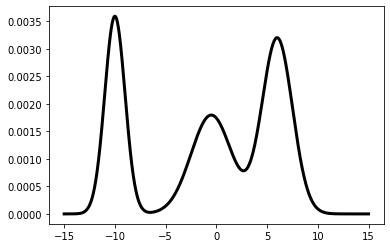

In [3]:
plt.plot(t,p,'k',linewidth=3)
plt.show()

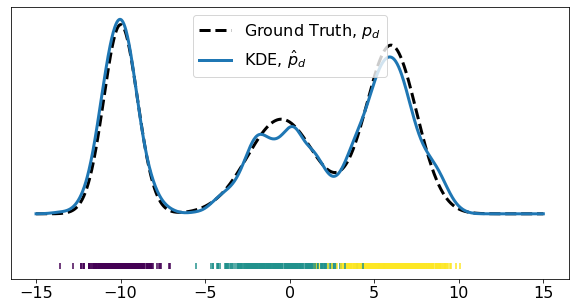

In [4]:
figure=plt.figure(figsize=(10,5))
q=np.exp(kde.score_samples(t[:,np.newaxis]))
q/=q.sum()
plt.plot(t,p,'k--',linewidth=3,label=r'Ground Truth, $p_d$') 
plt.plot(t,q,linewidth=3,label=r'KDE, $\hat{p}_d$')
plt.scatter(samples,-.001*np.ones_like(samples),marker='|',c=label)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([])
plt.legend(fontsize=16)
plt.show()

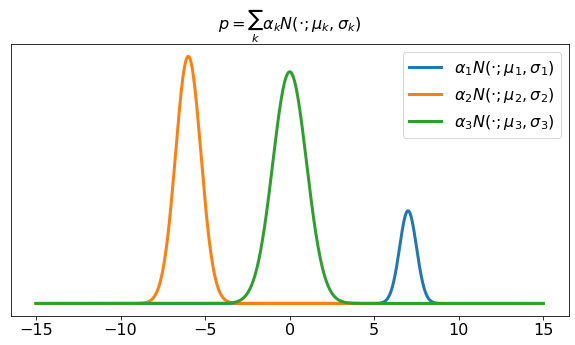

In [5]:
alphas = [.1,.4,.5]
sigmas = [.5,.75,1.]
means  = [7.,-6.,0.]
fig=plt.figure(figsize=(10,5))
p=np.zeros_like(t)
for i in range(3):
    temp=alphas[i]*gaussian1d(t,means[i],sigmas[i])
    p += temp
    plt.plot(t,temp,linewidth=3,label=r'$\alpha_{%d} N(\cdot;\mu_{%d},\sigma_{%d})$'%(i+1,i+1,i+1))

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([])
plt.legend(fontsize=16)
plt.title(r'$p=\sum_k \alpha_k N(\cdot;\mu_k,\sigma_k)$',fontsize=16)
plt.show()

In [6]:
def diff_gaussian1d(t,mu,sigma,wrt='mu'):
    f=(1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-((t-mu)**2)/(2*sigma**2))
    if wrt=='mu':        
        out = ((t-mu)/(sigma**2))*f
    elif wrt=='sigma':
        out =(f/sigma)*((((t-mu)**2)/(sigma**2))-1.)
    else: 
        raise Exception('undefined variable')
    return out

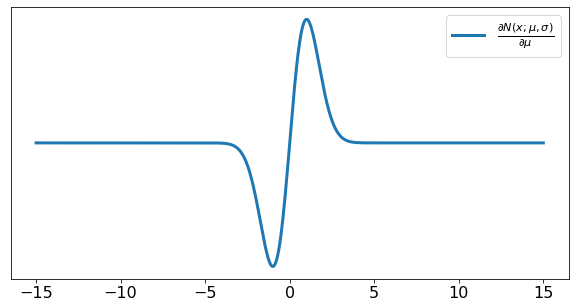

In [7]:
temp=diff_gaussian1d(t,0,1)
fig=plt.figure(figsize=(10,5))
plt.plot(t,temp,linewidth=3,label=r'$\frac{\partial N(x;\mu,\sigma)}{\partial \mu}$')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([])
plt.legend(fontsize=16)
plt.show()

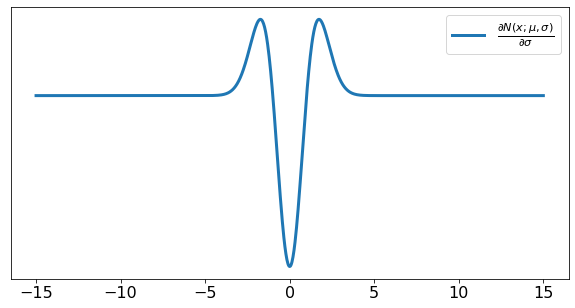

In [8]:
temp=diff_gaussian1d(t,0,1,wrt='sigma')
fig=plt.figure(figsize=(10,5))
plt.plot(t,temp,linewidth=3,label=r'$\frac{\partial N(x;\mu,\sigma)}{\partial \sigma}$')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([])
plt.legend(fontsize=16)
plt.show()

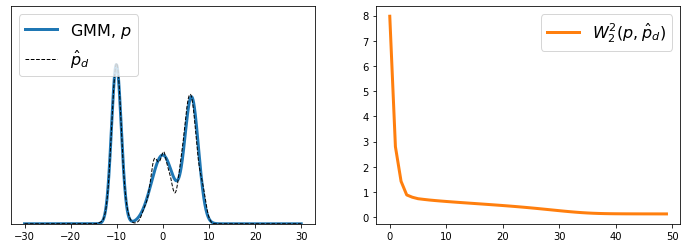

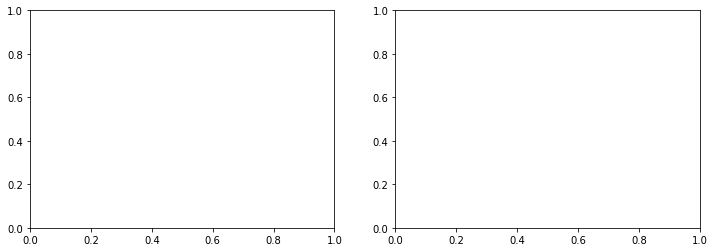

In [9]:
i=0
t=np.linspace(-30,30,5000)
dt=t[1]-t[0]

kde=KernelDensity(bandwidth=.5).fit(samples[:,np.newaxis])
lr=100.
lra=.1

alphas = [1./3.,1./3.,1./3.]
sigmas = [3.,3.,3.]
means  = [-18.,-7.,+10.]

loss=[]
K= len(means)

q=np.exp(kde.score_samples(t[:,np.newaxis]))
q/=q.sum()

p=gmm1d(t,means,sigmas,alphas)

fig,ax=plt.subplots(1,2,figsize=(12,4))
for iteration in range(50):    
    
    # Calculate the Wasserstein distance and transport map
    f,phi,Wp=pWasserstein(p,q,2)
    loss.append(Wp)
    u=dt*(f-np.arange(p.shape[0]))
    
    # Plot the results
    ax[0].plot(t,p,linewidth=3,label=r'GMM, $p$')
    ax[0].plot(t,q,'k--',linewidth=1,label=r'$\hat{p}_d$')
    ax[0].legend(fontsize=16,loc='upper left')
    ax[0].set_ylim(0,.002)
    ax[0].set_yticks([])
    
    ax[1].plot(np.asarray(loss),c='C1',linewidth=3,label=r'$W_2^2(p,\hat{p}_d)$')
    ax[1].legend(fontsize=16,loc='upper right')
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(1e-3)           
    for i in range(2):
        ax[i].clear()
    
    # Calculate the gradients and update parameters with gradient descent
    for i in range(K):        
        dmu = alphas[i]*((phi)*diff_gaussian1d(t,means[i],sigmas[i],wrt='mu')).mean()
        dsigma = alphas[i]*((phi)*diff_gaussian1d(t,means[i],sigmas[i],wrt='sigma')).mean()
        dalpha = ((phi)*gaussian1d(t,means[i],sigmas[i])).mean()

        means[i] = means[i]-lr*dmu
        sigmas[i] = max(sigmas[i]-lr*dsigma,0.)
        alphas[i] = max(alphas[i]-lra*dalpha,0.)
    
    alpha_sum=np.sum(alphas)
    alphas= [a/alpha_sum for a in alphas]    
    
    # Update the gmm
    p=gmm1d(t,means,sigmas,alphas)
    
    